# Creating Materials from Python

In [1]:
import opensees
from opensees import uniaxial, tcl

In [2]:
from jax.numpy import linspace, logspace, sin, cos, pi, sign
import matplotlib.pyplot as plt
plt.style.use("typewriter")

In [3]:
m = opensees.model(ndm=2,ndf=3)
rt = tcl.TclRuntime()
rt.model(m)
from opensees import libOpenSeesRT

In [4]:
class UniaxialMaterial(libOpenSeesRT._UniaxialMaterial):
    def __enter__(self):
        self.stress = 0.0
        self.strain = 0.0
        self.revertToStart()
        return self
    
    def __exit__(self, *args, **kwds):
        self.revertToStart()
    
    def getCopy(self):
        return self

## Material without State (Elastic)

In the first example, an elastic material is defined from Python. This is joined
with the classical hardening plasticity model of OpenSees (`uniaxial.Hardening`)
using the `Parallel` wrapper to add the effect of kinematic hardening.

In [5]:
class Elastic(UniaxialMaterial):
    def __init__(self, name, E):
        "Create a new material"
        self.name = str(name)
        self.tangent = E
        self.revertToStart()
        UniaxialMaterial.__init__(self, int(self.name))

    def getCopy(self):
        new = Elastic(self.name, self.tangent)
        return new
      
    def revertToStart(self):
        "Initialize or revert state"
        self.stress = 0.0
        self.strain = 0.0
        return 0

    def setTrialStrain(self, strain, commit=False):
        "Compute trial stress update"
        self.trial_strain = strain
        self.stress = strain*self.tangent
        return 0

    def getStress(self, *args, **kwds):
        if len(args) > 0:
            self.setTrialStrain(args[0])
            if "commit" in kwds:
                self.commitState()
        return self.stress

    def getTangent(self):
        return self.tangent

    def getInitialTangent(self):
        return self.tangent

    def getDampTangent(self):
        return self.tangent

    def commitState(self):
        self.strain = self.trial_strain
        return 0


In [6]:
pymat = Elastic(1, 500)

In [7]:
pymat.setTrialStrain(3.0)
pymat.getStress(3.0, commit=True)

1500.0

### Parallel Composition

In [8]:
n = 100
strain = 0.02*sin(linspace(0, 10*pi, n))*linspace(0.5, 1, n)**2

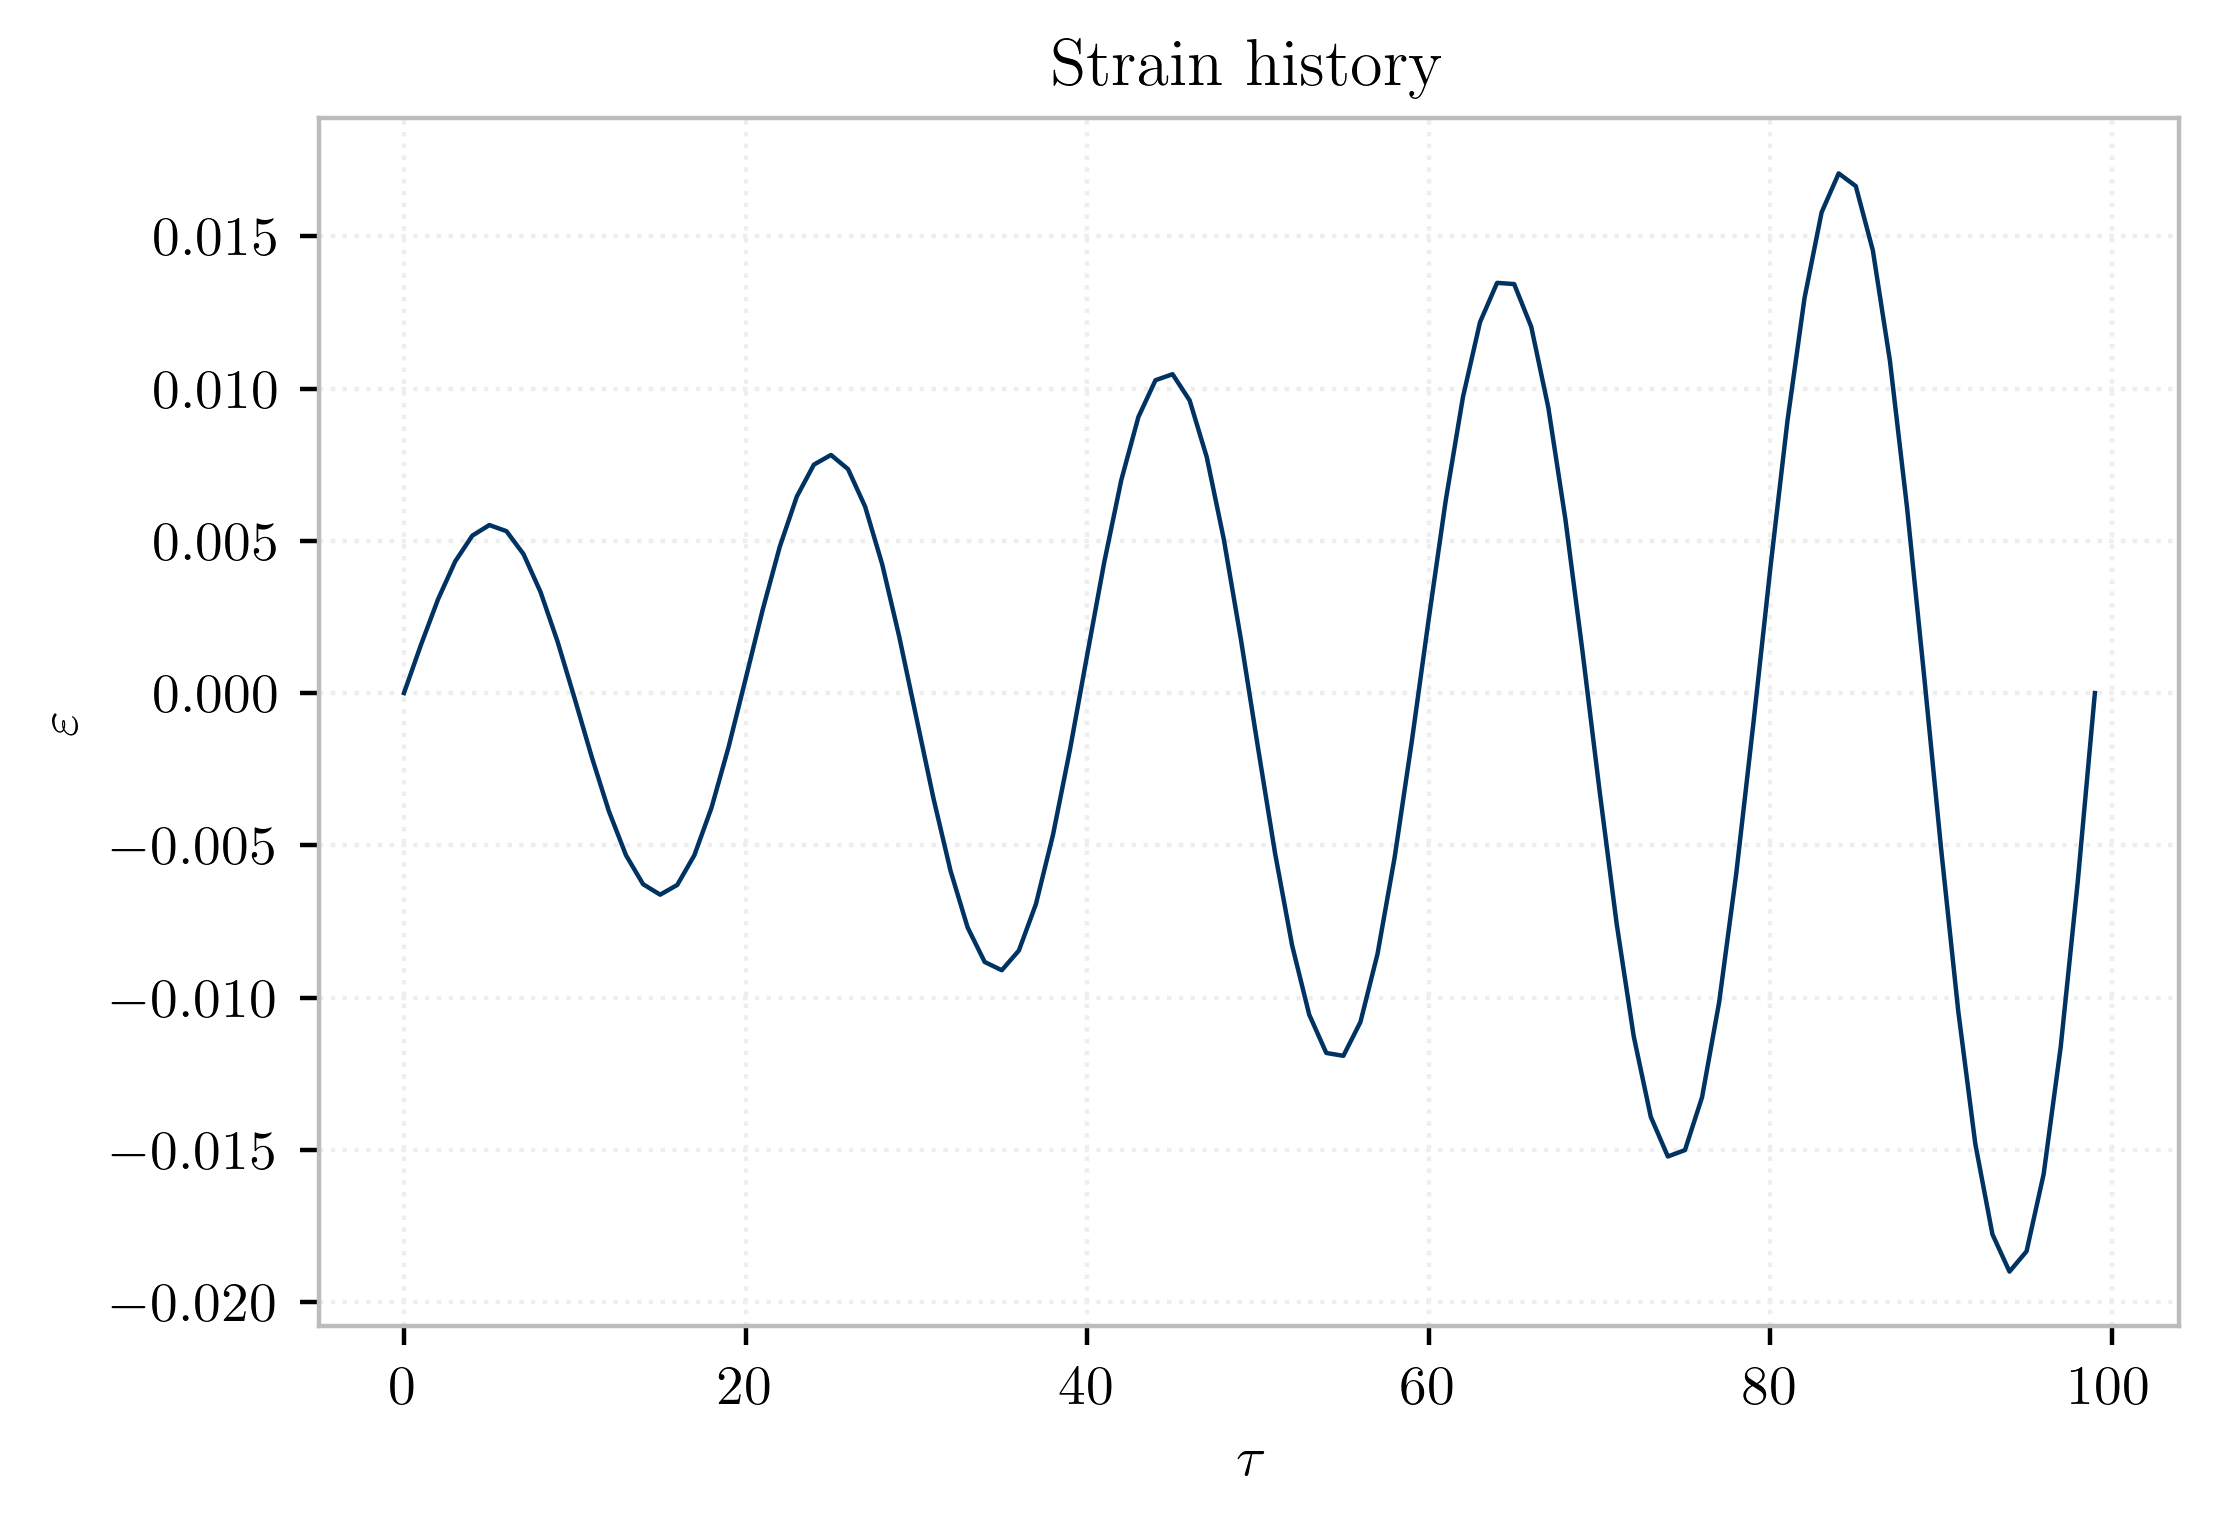

In [9]:
fig, ax = plt.subplots()
ax.plot(strain)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Strain history");

Create an instance of the OpenSees `Hardening` material (this is implemented in C++):

In [10]:
mat_a = uniaxial.Hardening(2, 15e3, fy=15., H_iso=50., H_kin=5e0)

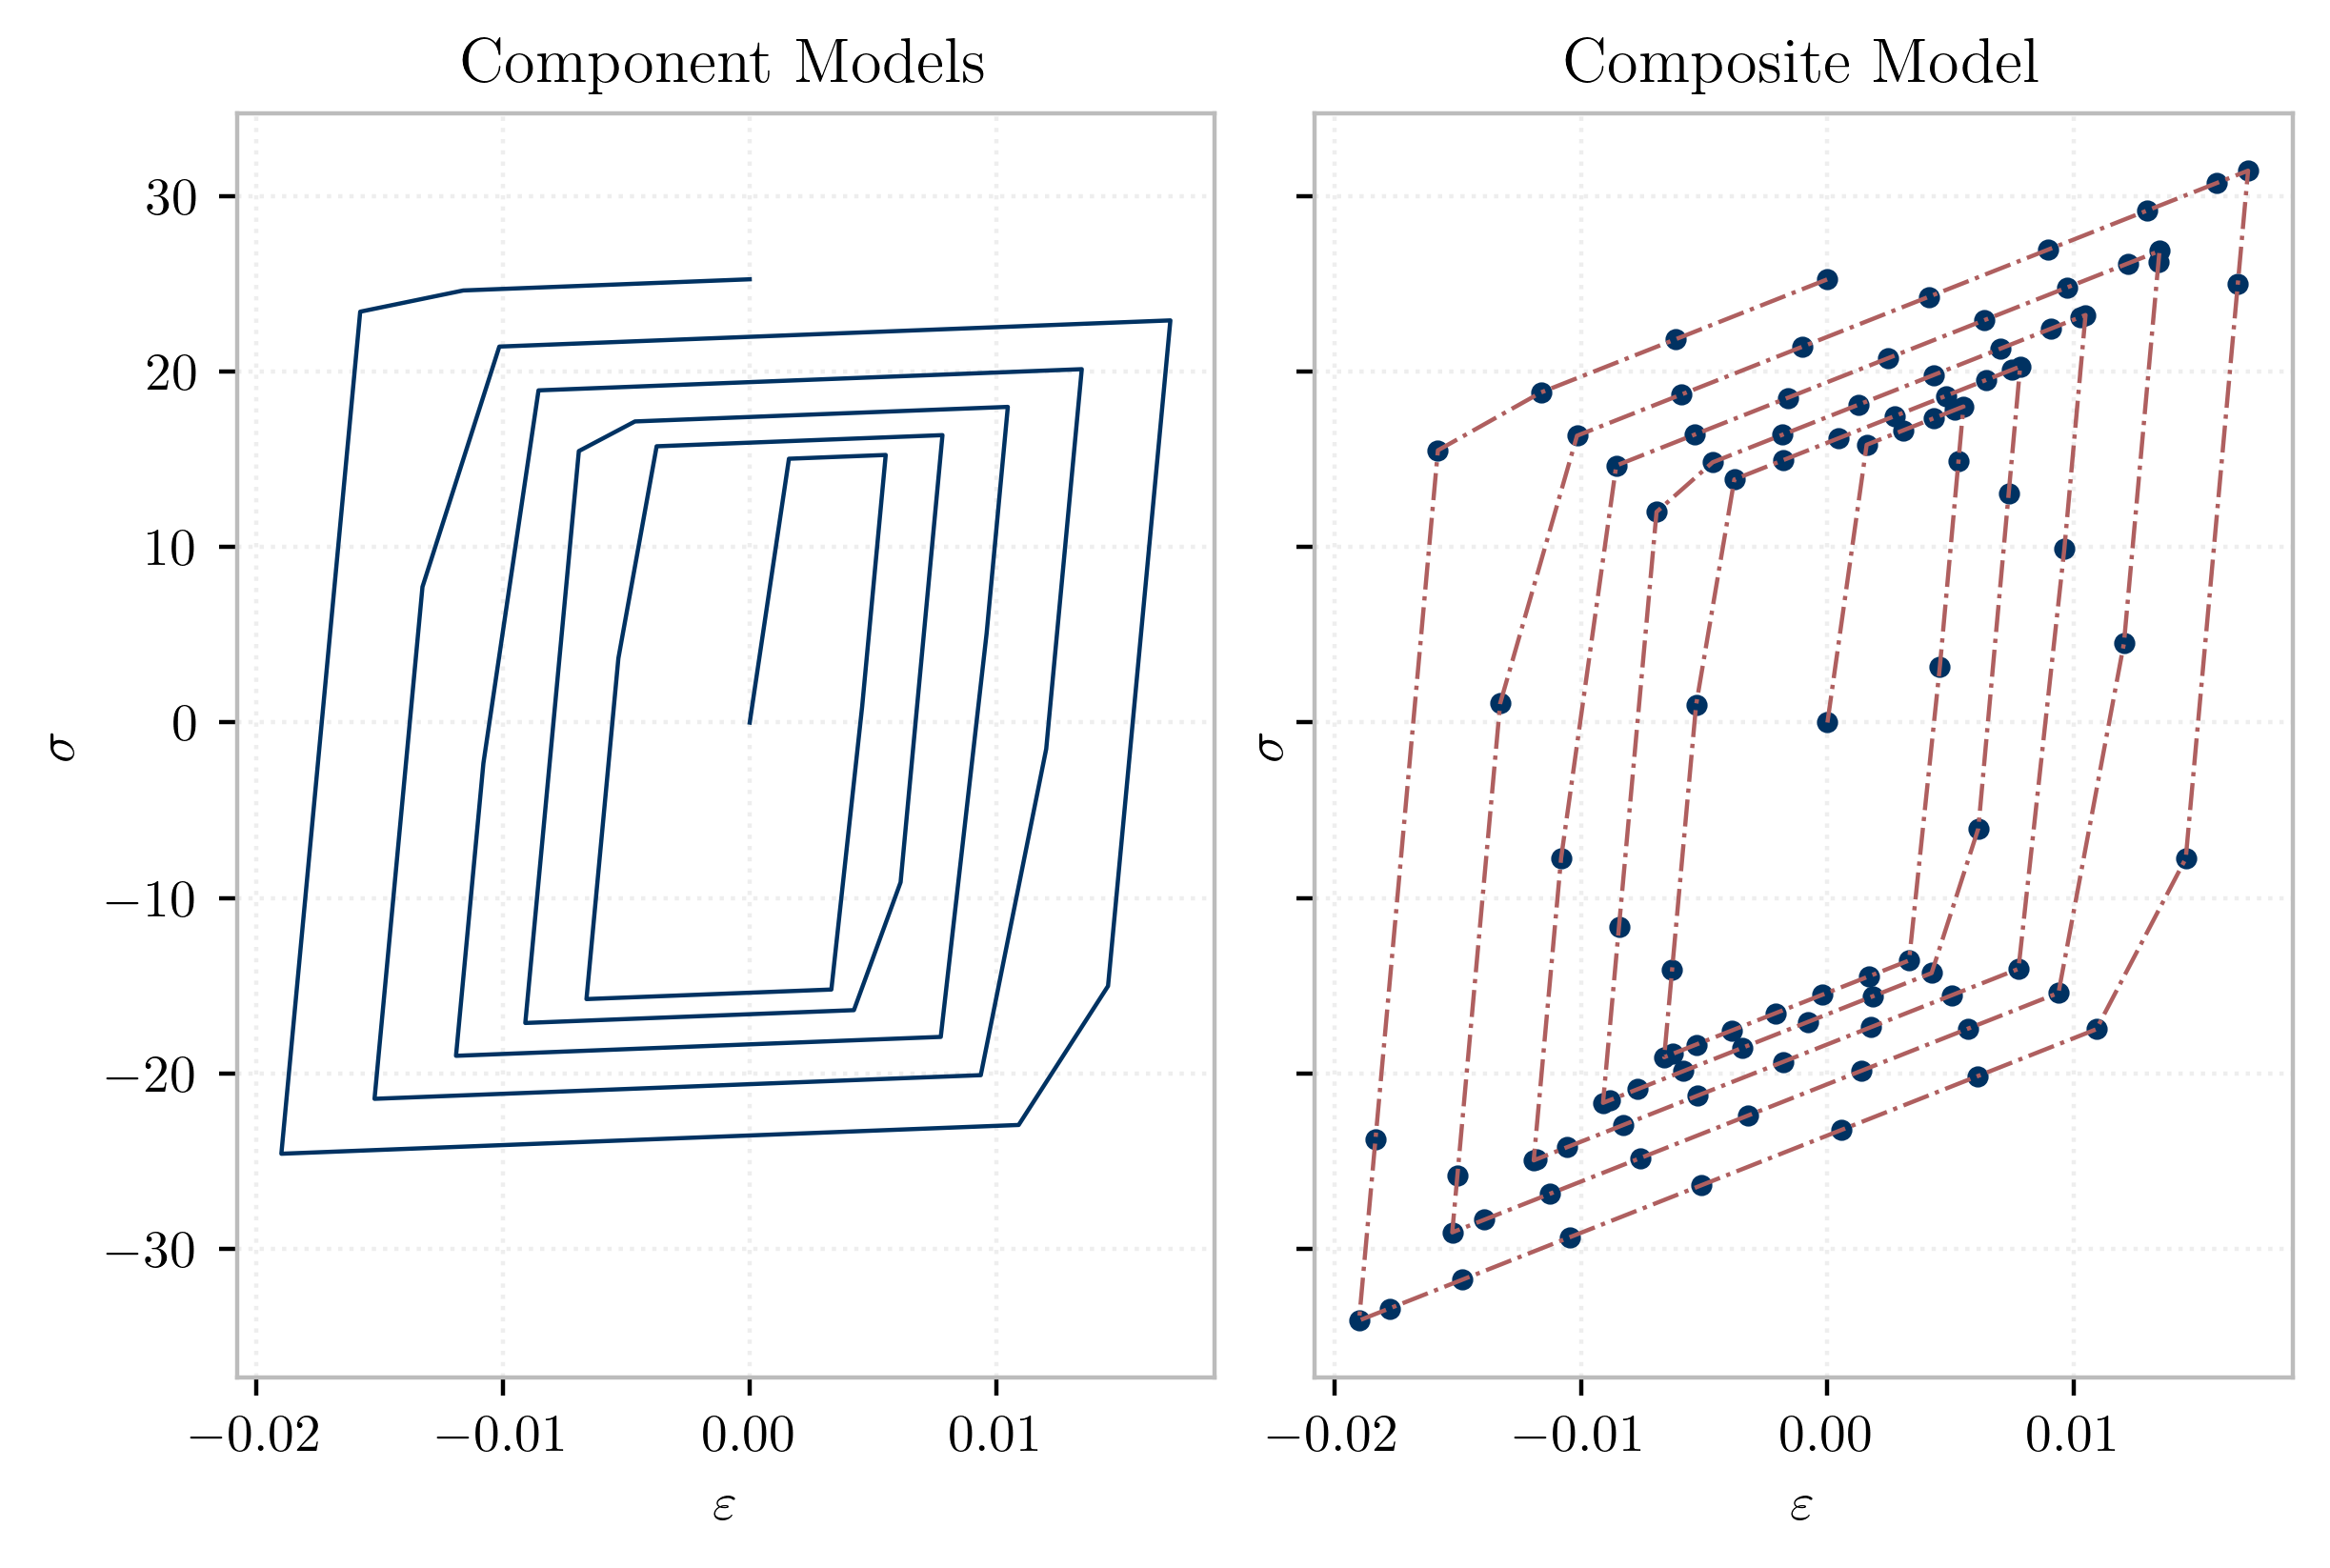

In [11]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

with mat_a as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])

with uniaxial.Parallel(3, [mat_a, pymat]) as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain], ".")

# Plot
with uniaxial.Parallel(3, [mat_a, uniaxial.Elastic(4, pymat.getInitialTangent())]) as m:
    stress = [m.getStress(e, commit=True) for e in strain]
    ax[1].plot(strain, stress, "-.")


# Plot formatting
ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");

## Material with State (Bouc-Wen-Baber Model)


[doi: 10.1061/JMCEA3.0002768](https://doi.org/10.1061/JMCEA3.0002768)

> The Bouc-Web-Baber model is a univariate hysteretic relation that exhibits
> strength and stiffness degradation. Stress is prescribed by the following
> expression:
> $$
  \sigma=\alpha k_{o} \epsilon+(1-\alpha) k_{o} z
  $$
> Where $z$ evolves according to the following IVP
> $$
  \left\{
  \begin{array}
  \dot{z}=\dfrac{\partial z}{\partial \epsilon} \dfrac{\partial \epsilon}{\partial t}  
         =\dfrac{A-|z|^{n}\{\beta \operatorname{sgn}(\dot{\epsilon} z)+\gamma\} \nu}{\eta} \dot{\epsilon}\\
  \dot{e} =(1-\alpha) k_{o} \dot{\epsilon} z
  \end{array}
  \right.
  $$
> and the following relations:
> $$
  \begin{aligned}
  A &=A_{o}-\delta_{A} e \\
  \nu &=1+\delta_{\nu} e \\
  \eta &=1+\delta_{\eta} e 
  \end{aligned}
  $$
> $A_{o}$, $\delta_{A}$, $\delta_{\nu}$  and $\delta_{\eta}$ are user-defined parameters. 
>

In [12]:
from scipy.integrate import solve_ivp

class BoucWenBaber(UniaxialMaterial):
    "Bouc, Wen and Baber model from Baber and Wen 1981"
    def __init__(self, name, A0, 𝛾, β, n, k0=0, n1=0, n2=0, n3=0):
        self.parameters = A0, 𝛾, β, n, k0, n1, n2, n3
        self.name = str(name)
        self.revertToStart()
        UniaxialMaterial.__init__(self, int(self.name))
    
    def revertToStart(self):
        self.state = [0., 0.]
        self.strain = 0.0
        self.stress = 0.0
        self.tangent = 0.0
        return 0

    def getStress(self, *args, **kwds):
        if len(args) > 0:
            self.setTrialStrain(args[0])
            if "commit" in kwds:
                self.commitState()
        return self.stress
    
    def getTangent(self):
        return self.tangent

    def getInitialTangent(self):
        return self.tangent

    def getDampTangent(self):
        return self.tangent
         
    def commitState(self): return 0

    def setTrialStrain(self, ε, *args, **kwds):
        ε0 = self.strain
        z0, e0 = self.state
        A0, 𝛾, β, n, k0, n1, n2, n3 = self.parameters

        dε = ε - ε0
        def f(ε, y):
            # Damage history variables
            A_  = A0 - n1*y[1]
            nu  =  1 + n2*y[1]
            eta =  1 + n3*y[1]
            dz  = (A_ - nu*(β*sign(dε*y[0]) + 𝛾)*abs(y[0])**n)/eta
            de  = k0*y[0]
            return [dz, de]

        soln = solve_ivp(f, (ε - dε, ε), [z0, e0])
        if soln.success:
            self.strain += dε
            self.state = soln.y[:,-1].T
            self.stress = soln.y[0,-1]
        else:
            raise ValueError("Failed to solve Bouc-Wen IVP.")

        return 0

In [17]:
hysteresis = BoucWenBaber(1, 1.0, β = 4.0, 𝛾 = 0.8, n = 1.0, k0 = 10.0)

In [18]:
strain = sin(linspace(0.01, 10.5*pi, 200))
hardening  = Elastic(2, 0.1)
parallel   = uniaxial.Parallel(3, [hysteresis, hardening])

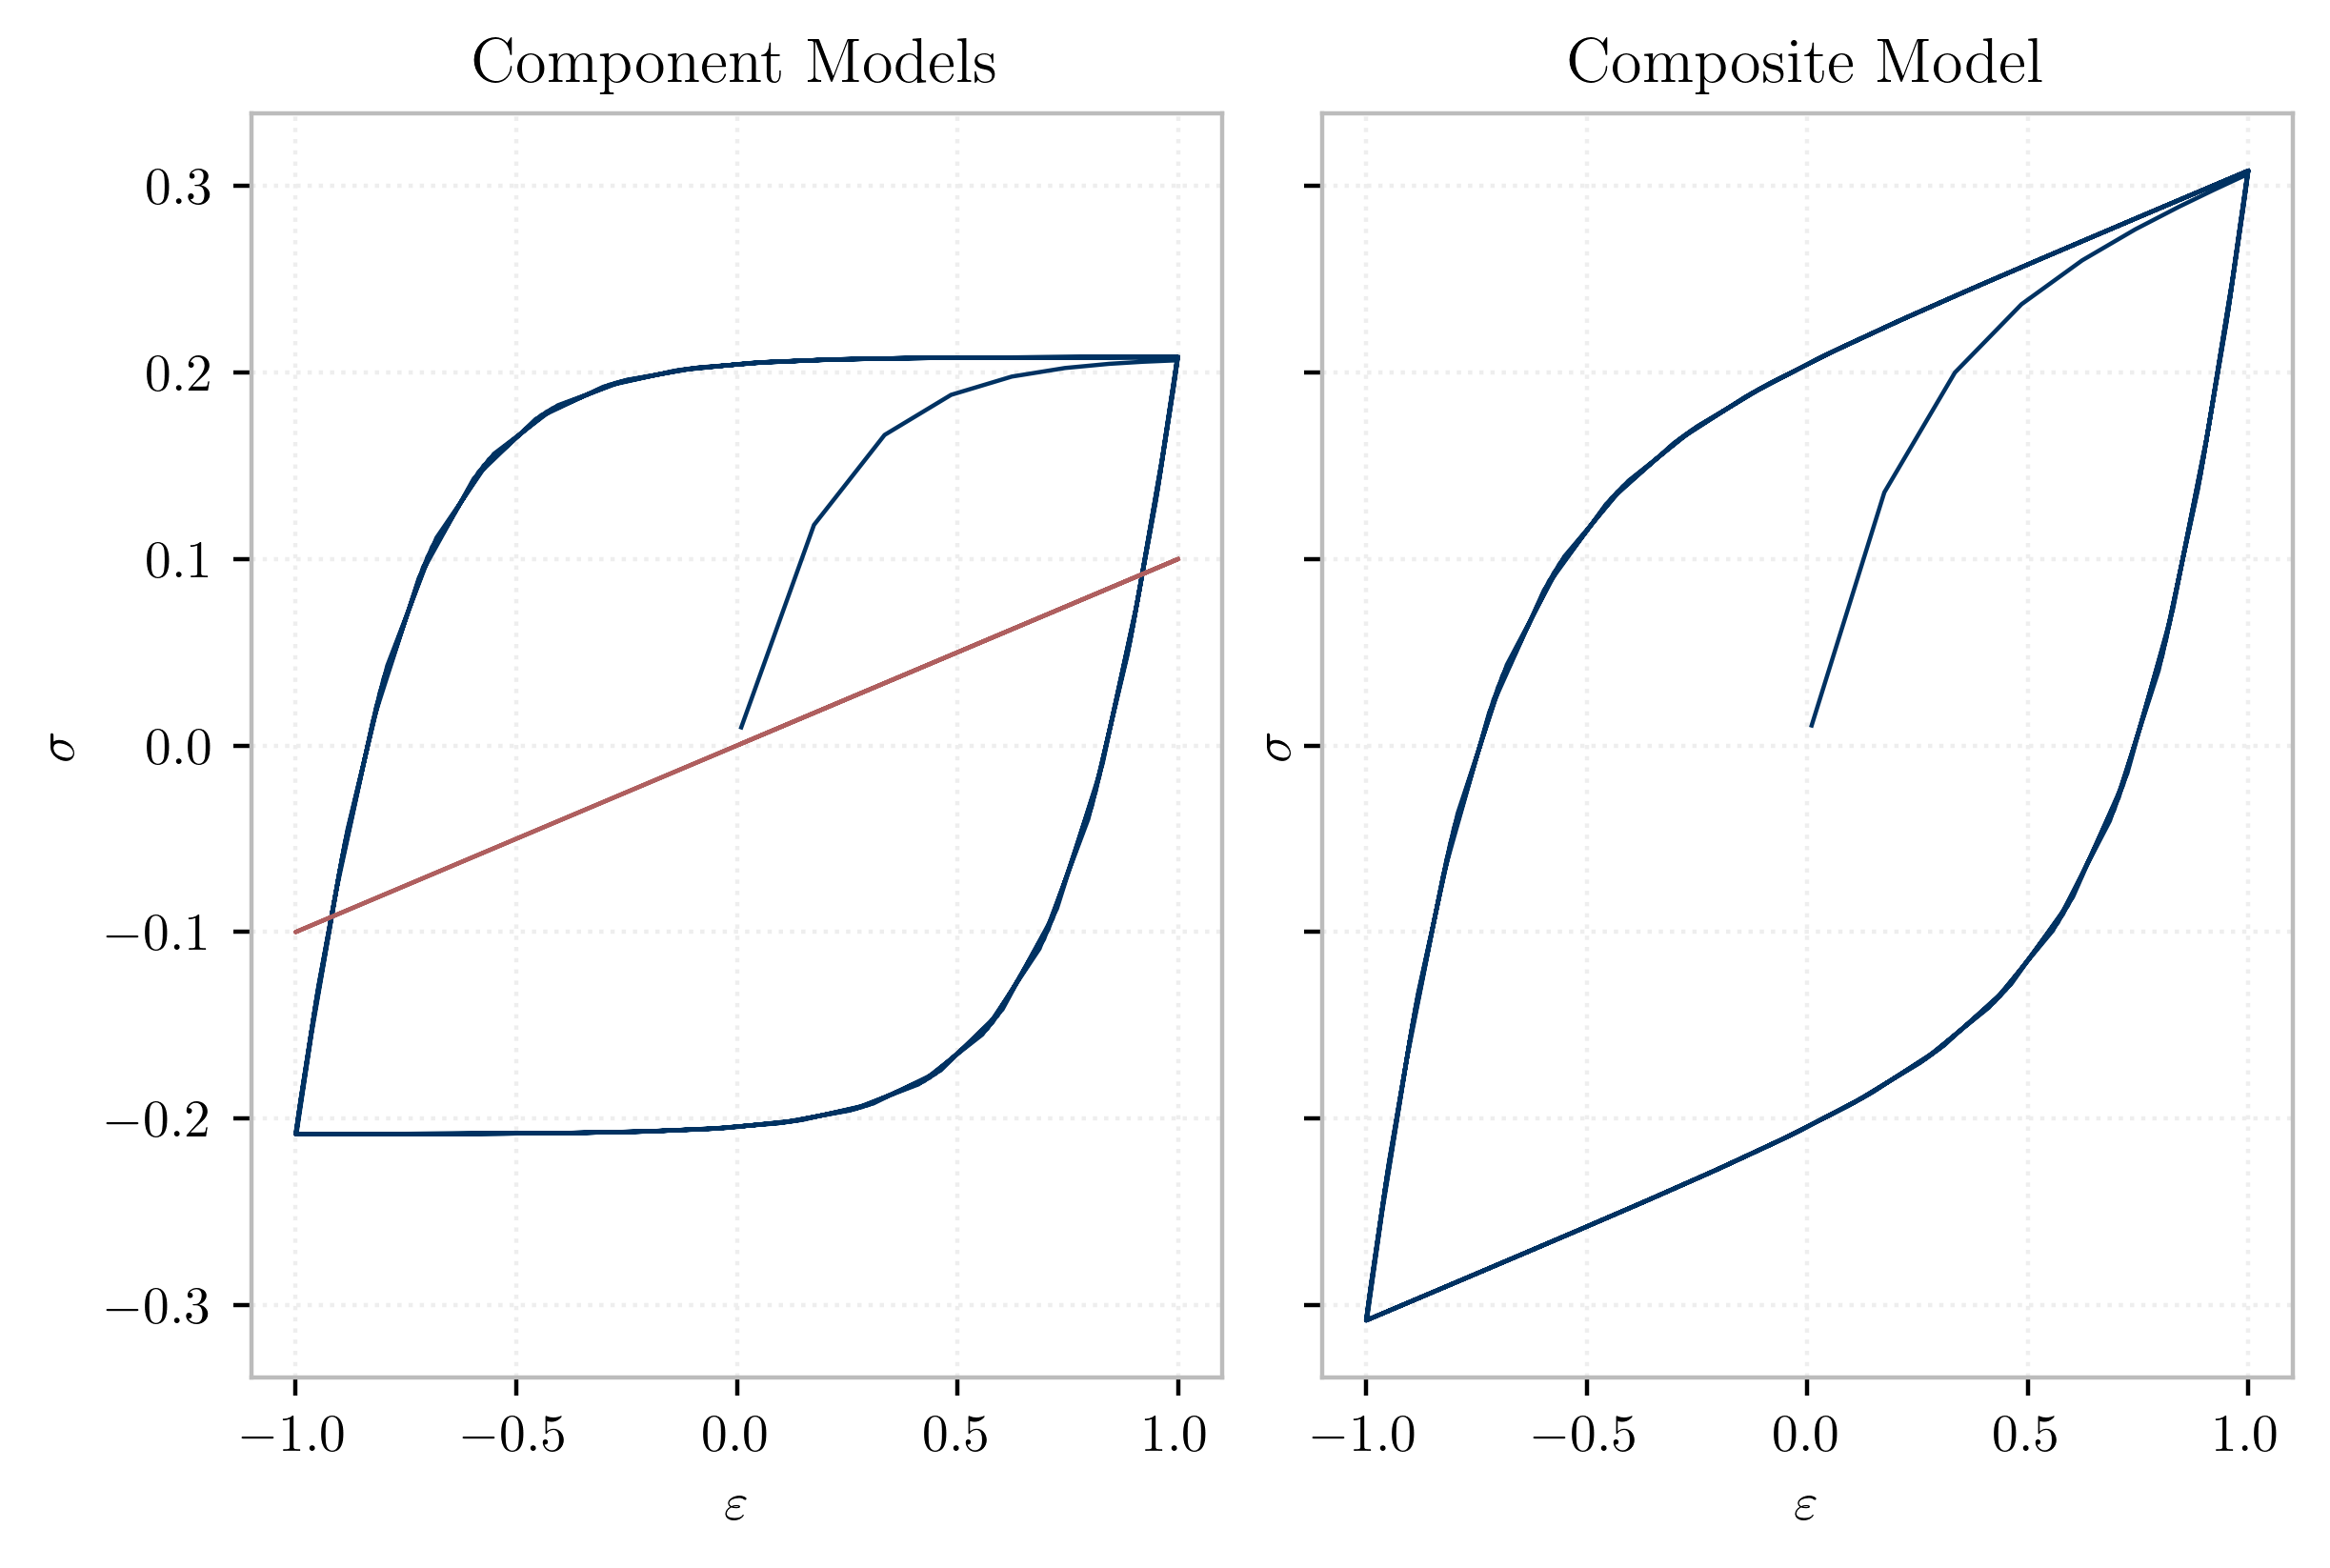

In [19]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

with hysteresis as m:
    stress = [m.getStress(e, commit=True) for e in strain]
    ax[0].plot(strain, stress)

with hardening as m:
    stress = [m.getStress(e, commit=True) for e in strain]
    ax[0].plot(strain, stress)

with parallel as m:
    stress = [m.getStress(e, commit=True) for e in strain]
    ax[1].plot(strain, stress)


ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");

## Implementation details

    opensees.ParallelMaterial::__enter__(self):
        - C++: Create Tcl_Interp interp;
        - C++: Create G3_Runtime rt;
        - C++: Tcl_AddAssocData(interp, rt);
        - tcl_model = opensees._TclModel(self)
        - for obj in tcl_model.python_objects:
             rt.builder.addPythonObject(obj.name, obj)
        - interp->eval(tcl_model.getScript())
        
        - return builder.getPythonObject(self.name)
        